In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# ML
# for transformers creation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# models and metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
# distributions for random search
from scipy.stats import randint, expon, reciprocal

sns.set(rc={'figure.figsize':(20, 15)})

In [3]:
import joblib  # for saving models from skikit-learn

# some utils for saving and reading later
def save(model, cv_info, classification_report, name="model", cv_scores=None):
    _model = {
        "cv_info": cv_info, "classification_report": classification_report, "model": model, "cv_scores": cv_scores
    }
    joblib.dump(_model, "./models_saved/" + name + ".pkl")


def load(name="model", verbose=True, with_metadata=False):
    _model = joblib.load("./models_saved/" + name + ".pkl")
    if verbose:
        print("\nLoading model with the following info:\n")
        [print("{key}: {val}".format(key=key, val=val)) for key, val in _model["cv_info"].items()]
        print("\nClassification Report:\n")
        print(_model["classification_report"])
    if not with_metadata:
        return _model["model"]
    else:
        return _model

In [4]:
for dirname, _, filenames in os.walk('./datasets/titanic'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./datasets/titanic/gender_submission.csv
./datasets/titanic/test.csv
./datasets/titanic/train.csv


In [5]:
train = pd.read_csv('./datasets/titanic/train.csv')
test = pd.read_csv('./datasets/titanic/test.csv')

In [6]:
train.head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

The attributes have the following meaning:

* **Survived**: Survival (0 = No; 1 = Yes)

* **Pclass**: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* **Name, Sex, Age**: Name, Sex and Age of passenger
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in Brittish pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Visualize some of the categorical attributes

In [8]:
train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [9]:
train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [11]:
# train["Name"].value_counts() as imagined are uniques
# train["Ticket"].value_counts() is not unique, but has some few repetitions
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [12]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

# Pandas Profiling

 * Good for a quick overview of the data

In [13]:
import pandas_profiling 

train.profile_report()

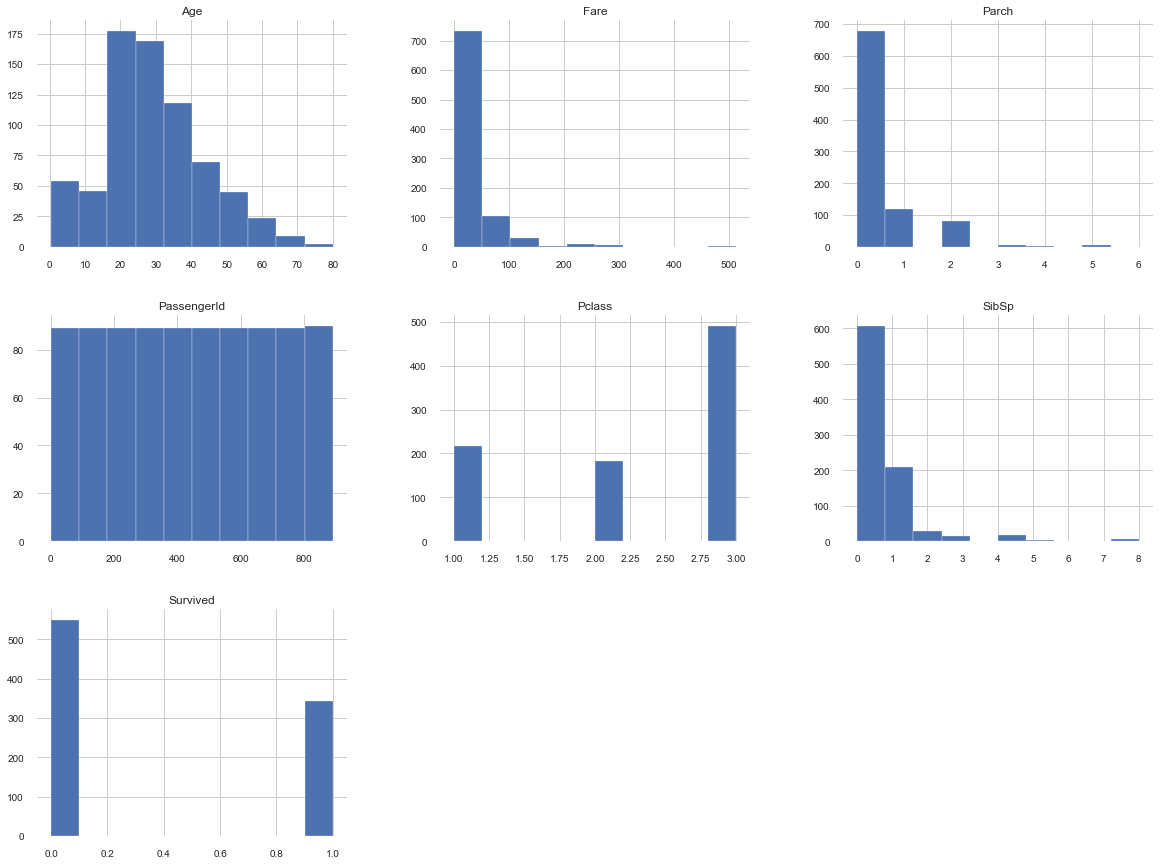

In [14]:
train.hist(figsize=(20, 15))
plt.show()

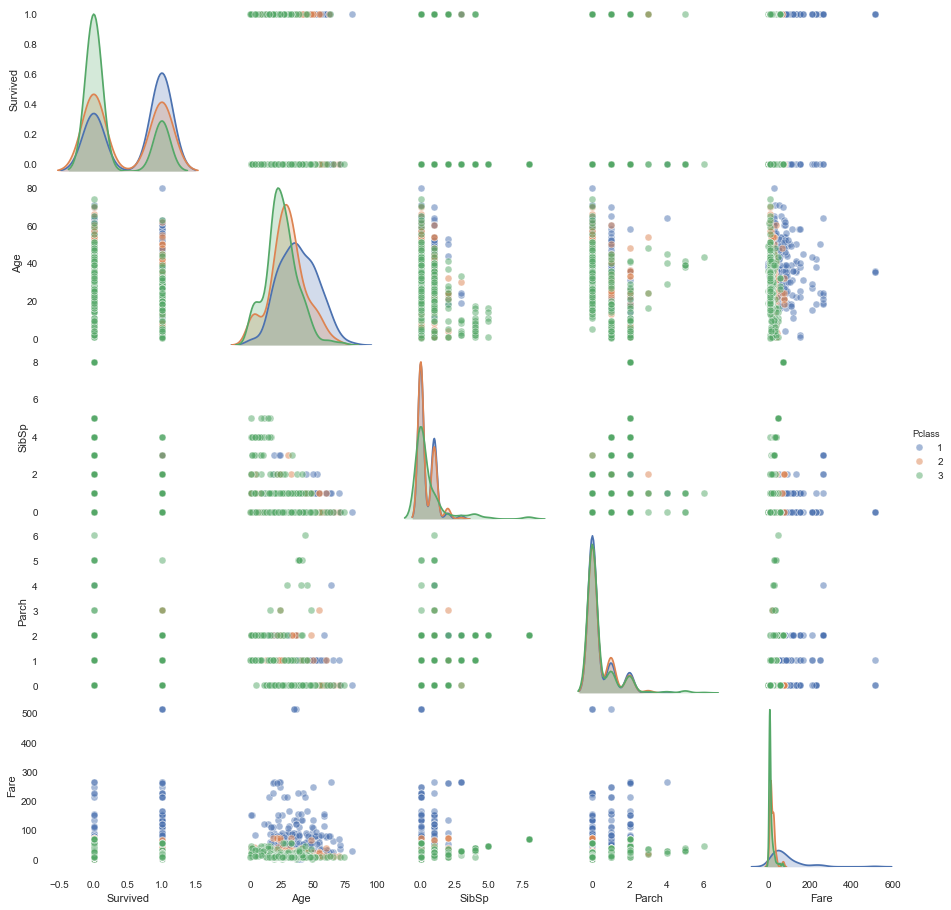

In [15]:
# from pandas.plotting import scatter_matrix

attributes = ["Survived", "Pclass","Age", "SibSp", "Parch", "Fare"]
plt_att = train[attributes]
sns.pairplot(plt_att, hue="Pclass", plot_kws={'alpha': 0.5})
plt.show()

In [16]:
corr_matrix = train.corr()
corr_matrix["Survived"]

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

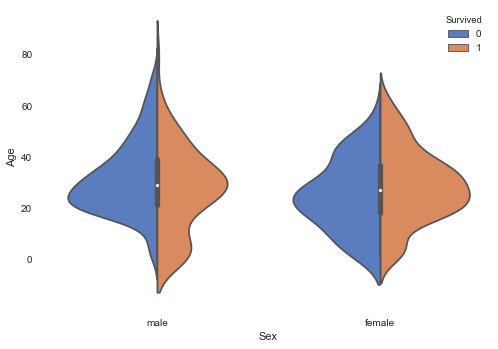

In [17]:
# hypothesis for feature engineering "women and children first"
sns.violinplot(x="Sex", y="Age", hue="Survived",
                    data=train, palette="muted", split=True)
plt.show()

# Feature Engineering

In [18]:
# Hypotesis: since the survived looks like "bimodal" near 15 years, we should try to see 
# the correlation of categorizing if the passenger is less than 15 years

train["Age"] = train["Age"] // 15 * 15
train[["Age", "Survived"]].groupby(['Age']).mean()

Survived
Age           
0.0   0.576923
15.0  0.362745
30.0  0.423256
45.0  0.404494
60.0  0.240000
75.0  1.000000

In [19]:
train["RelativesOnboard"] = train["SibSp"] + train["Parch"]
# train[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()
train[["RelativesOnboard", "Survived"]].groupby(["RelativesOnboard"]).mean()

Survived
RelativesOnboard          
0                 0.303538
1                 0.552795
2                 0.578431
3                 0.724138
4                 0.200000
5                 0.136364
6                 0.333333
7                 0.000000
10                0.000000

In [20]:
# count total family members look to have a better discrimination on survival rate
# since number of siblings is nearer to the mean survival rate 38% 
train[["SibSp", "Survived"]].groupby(['SibSp']).mean()

Survived
SibSp          
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000

In [21]:
train[["Parch", "Survived"]].groupby(['Parch']).mean()

Survived
Parch          
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000

In [22]:
# Age grouped by 15 years have near 0 correlation, but some groups have more survival rate than others
# this only means that the relation of age groups and survival rate are non-linear
train.corr()

PassengerId  Survived    Pclass       Age     SibSp  \
PassengerId          1.000000 -0.005007 -0.035144  0.051251 -0.057527   
Survived            -0.005007  1.000000 -0.338481 -0.058848 -0.035322   
Pclass              -0.035144 -0.338481  1.000000 -0.372547  0.083081   
Age                  0.051251 -0.058848 -0.372547  1.000000 -0.295038   
SibSp               -0.057527 -0.035322  0.083081 -0.295038  1.000000   
Parch               -0.001652  0.081629  0.018443 -0.189475  0.414838   
Fare                 0.012658  0.257307 -0.549500  0.098173  0.159651   
RelativesOnboard    -0.040143  0.016639  0.065997 -0.293841  0.890712   

                     Parch      Fare  RelativesOnboard  
PassengerId      -0.001652  0.012658         -0.040143  
Survived          0.081629  0.257307          0.016639  
Pclass            0.018443 -0.549500          0.065997  
Age              -0.189475  0.098173         -0.293841  
SibSp             0.414838  0.159651          0.890712  
Parch             1.000000  0.216225          0.783111  
Fare              0.216225  1.000000          0.217138  
RelativesOnboard  0.783111  0.217138          1.000000

# Transformers

In [23]:
# Transformers created by https://github.com/ageron/handson-ml2

# this transformers we will choose which attributes, late numerical and categorical
# to use some input strategies
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)


class AgeGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, new_attribute="AgeGrp", attribute_name="Age", group_scale=15, del_originals=True):
        self.group_scale = group_scale
        self.attribute_name = attribute_name
        self.new_attribute = new_attribute
        self.del_originals = del_originals

    def fit(self, X, y=None):
        self.age_groups = X[self.attribute_name] // self.group_scale * self.group_scale
        return self

    def transform(self, X, y=None):
        X[self.new_attribute] = self.age_groups
        if self.del_originals:
            X.drop(columns=self.attribute_name, axis=1, inplace=True)
        return X


class AtributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, new_attribute="RelativesOnboard", attribute_names=["SibSp", "Parch"], del_originals=True):
        self.attribute_names = attribute_names
        self.final_attr = 0
        self.new_attribute = new_attribute
        self.del_originals = del_originals

    def fit(self, X, y=None):
        for attr in self.attribute_names:
            self.final_attr += X[attr]
        return self

    def transform(self, X, y=None):
        X[self.new_attribute] = self.final_attr
        if self.del_originals:
            X.drop(columns=self.attribute_names, axis=1, inplace=True)
        return X

In [24]:
# Numerical Pipeline
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "Fare", "SibSp", "Parch"])),
        ("age_grouper", AgeGrouper(attribute_name="Age", group_scale=15)),
        ("total_relatives", AtributesAdder(attribute_names=["SibSp", "Parch"], del_originals=True)),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [25]:
# Categorical Pipeline
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [26]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [27]:
X_train = preprocess_pipeline.fit_transform(train)
y_train = train["Survived"]

X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(
        X_train, y_train, test_size=0.3, random_state=42)

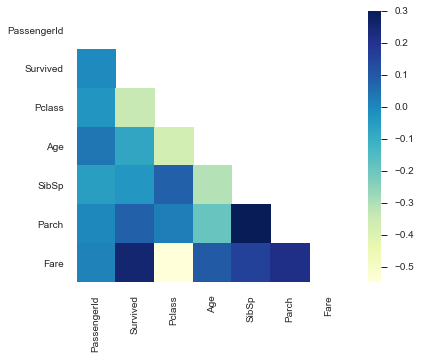

In [28]:
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr_matrix, mask=mask, vmax=.3, square=True, cmap="YlGnBu")

# Search for best model

* User random search for better hyperparams
* then use cross validation for model metrics

In [29]:
models = {
    "KNeighborsClassifier": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
}

randomized_params = {
    "KNeighborsClassifier": {
        "n_neighbors": randint(low=1, high=30),
    },
    "RandomForest": {
        "n_estimators": randint(low=1, high=200),
        "max_features": randint(low=1, high=8),
    },
    "SVM": {
        "kernel": ["linear", "rbf"],
        "C": reciprocal(0.1, 200000),
        "gamma": expon(scale=1.0),
    }
}

## Random Search script

In [30]:
scoring = "accuracy"

# # for model_name in models.keys():
# for model_name in ["RandomForest"]:
#     grid = RandomizedSearchCV(models[model_name], param_distributions=randomized_params[model_name], n_iter=100,
#                                   scoring=scoring, cv=5, verbose=2, random_state=42,  n_jobs=6)
#     grid.fit(X_train, y_train)

#     scores = cross_val_score(grid.best_estimator_, X_train_val, y_train_val, cv=10,
#                              scoring=scoring, verbose=0, n_jobs=6)

#     CV_scores = scores.mean()
#     STDev = scores.std()
#     Test_scores = grid.score(X_test_val, y_test_val)

#     cv_score = {'Model_Name': model_name, 'Parameters': grid.best_params_, 'Test_Score': Test_scores,
#                 'CV Mean': CV_scores, 'CV STDEV': STDev}

#     clf = grid.best_estimator_.fit(X_train_val, y_train_val)
#     clf.score(X_test_val, y_test_val)
#     y_pred = clf.predict(X_test_val)
#     clf_report = classification_report(y_test_val, y_pred)
#     save(grid, cv_score, clf_report, name="titanic_"+model_name+"_02", cv_scores=scores)

# Changelog on models

* First Run
    * tested only hyperparameters with randon search on ["Age", "Fare", "SibSp", "Parch"] and ["Pclass", "Sex", "Embarked"].
    * obtained 74% with random forests
    
* Second Run
    * Add some feature engineering with AgeGrouper and RelativesOnboard based on [Hands-On Machine Learning with Scikit-Learn and TensorFlow's repo](https://github.com/ageron/handson-ml2)
    * obtained 77% with random forests


In [31]:
_ = load("titanic_KNeighborsClassifier", with_metadata=True)


Loading model with the following info:

Model_Name: KNeighborsClassifier
Parameters: {'n_neighbors': 3}
Test_Score: 0.8880597014925373
CV Mean: 0.7142345110087047
CV STDEV: 0.03225985251751952

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       157
           1       0.71      0.52      0.60       111

    accuracy                           0.71       268
   macro avg       0.71      0.68      0.69       268
weighted avg       0.71      0.71      0.70       268



In [32]:
knn_grid = load("titanic_KNeighborsClassifier_02", with_metadata=True)


Loading model with the following info:

Model_Name: KNeighborsClassifier
Parameters: {'n_neighbors': 5}
Test_Score: 0.8432835820895522
CV Mean: 0.743215565796211
CV STDEV: 0.0398578950990077

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.84      0.80       157
           1       0.73      0.61      0.67       111

    accuracy                           0.75       268
   macro avg       0.74      0.73      0.73       268
weighted avg       0.74      0.75      0.74       268



In [33]:
_ = load("titanic_SVM", with_metadata=True)


Loading model with the following info:

Model_Name: SVM
Parameters: {'C': 129.24711698925614, 'gamma': 0.739678838777267, 'kernel': 'linear'}
Test_Score: 0.7835820895522388
CV Mean: 0.7848694316436251
CV STDEV: 0.07065514665245524

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       157
           1       0.76      0.70      0.73       111

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.78       268
weighted avg       0.79      0.79      0.79       268



In [34]:
svc_grid = load("titanic_SVM_02", with_metadata=True)


Loading model with the following info:

Model_Name: SVM
Parameters: {'C': 1440.7189571936603, 'gamma': 1.6994840726392213, 'kernel': 'linear'}
Test_Score: 0.8283582089552238
CV Mean: 0.7800819252432156
CV STDEV: 0.07925408885116851

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       157
           1       0.79      0.75      0.77       111

    accuracy                           0.81       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.81      0.81      0.81       268



In [35]:
_ = load("titanic_RandomForest", with_metadata=True)


Loading model with the following info:

Model_Name: RandomForest
Parameters: {'max_features': 5, 'n_estimators': 100}
Test_Score: 0.9888059701492538
CV Mean: 0.7995391705069124
CV STDEV: 0.04469682425181409

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       157
           1       0.72      0.71      0.71       111

    accuracy                           0.76       268
   macro avg       0.76      0.76      0.76       268
weighted avg       0.76      0.76      0.76       268



In [36]:
random_forest_grid = load("titanic_RandomForest_02_submitted", with_metadata=True)


Loading model with the following info:

Model_Name: RandomForest
Parameters: {'max_features': 7, 'n_estimators': 122}
Test_Score: 0.9365671641791045
CV Mean: 0.8155913978494624
CV STDEV: 0.044816478073043585

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       157
           1       0.75      0.75      0.75       111

    accuracy                           0.79       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.79      0.79      0.79       268



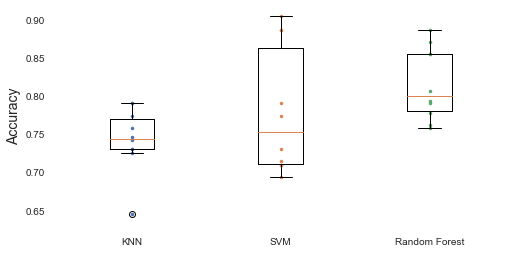

In [37]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, knn_grid["cv_scores"], ".")
plt.plot([2]*10, svc_grid["cv_scores"], ".")
plt.plot([3]*10, random_forest_grid["cv_scores"], ".")
plt.boxplot([knn_grid["cv_scores"], svc_grid["cv_scores"], random_forest_grid["cv_scores"]], labels=("KNN", "SVM", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [38]:
random_forest = random_forest_grid["model"].best_estimator_.fit(X_train, y_train)

In [39]:
test["RelativesOnboard"] = test["SibSp"] + test["Parch"]
test["AgeBucket"] = test["Age"] // 15 * 15

In [40]:
X_test = preprocess_pipeline.fit_transform(test)

In [41]:
y_pred = random_forest.predict(X_test)

In [42]:
submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = test['PassengerId']
submission_df['Survived'] = y_pred

In [43]:
submission_df.to_csv('submissions/titanic_02.csv', header=True, index=False)
submission_df.head(10)

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
5          897         1
6          898         0
7          899         0
8          900         1
9          901         0

# TODO: ROC curves for model analysis